<a href="https://colab.research.google.com/github/duyqu-chan/Humpback-Whale-Identification/blob/master/Humpback_Whale_Identification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humpback Whale Identification with Convolutional Neural Networks

## Capstone Project for Big Data Analytics Masters Program, MEF University

Duygu Can

November, 2018

Let's first import required libraries for the project.

In [0]:
from __future__ import print_function
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from PIL import ImageStat
import pickle
import tensorflow as tf
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform
from pylab import *
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
#import imagehash
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  BatchNormalization, Conv2D, MaxPooling2D
from keras.utils import plot_model
#import pydot
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import LearningRateScheduler
from keras.applications.resnet50 import ResNet50
from sklearn.preprocessing import MinMaxScaler
#from scipy.ndimage.interpolation import affine_transform
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


During development of the code, obtaining reproducible results for comparision is essential. This is the only way we can compare results from different runs and determine which parameter set gives best result. So following code snipet is borrowed from [Keras FAQ](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development).

In [0]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(123)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## About the Dataset

There are 9850 images in the train set and 15610 in the test set. Unfortunately test set is not labelled, so we have to split train set for testing and validation.

In [0]:
print(len(os.listdir("../input/train")))
#print(len(os.listdir("../input/test")))

FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: '../input/train'

Kaggle provided an Excel file, train.csv, which associates image names with whale IDs of the training set.

In [0]:
map = pd.read_csv("../input/train.csv")
map.head()

Some examples images from the dataset can be seen below.

In [0]:
randomRows = map.sample(frac=1.)[:10] # randomly choose 8 rows of the .csv file
filenames = list(randomRows['Image']) # convert Image column of the dataframe to filename list
labels = list(randomRows['Id']) # convert ID column of the dataframe to filename list
images = [imread(f'../input/train/{filename}') for filename in filenames] # using formatted string for changing filenames
                                                                      # create a list of arrays of rantomly chosen 10 images
figure = plt.figure(figsize=(20, 10)) # set figure size to 8 inches x 6 inches
rows = 2 # define # of rows
cols = 5 # define # of columns

for i in range(len(images)): # loop over images
    subplot = figure.add_subplot(rows, cols, i + 1) # add subplots to rows x columns figure grid
    subplot.axis('Off') #turn-off axis
    subplot.set_title(labels[i], fontsize=14) # set titles
    plt.imshow(images[i]) # show images
    
figure.savefig("../figures/flukes.png")

Notice that some of the images are black and white, while some of them are colored. The image sizes also vary. Not all of them are tagged with an unique ID, those that are not listed in the whale database are tagged as *new_whale*. Including those unspecified whales and other individual animals, there are 4251 different categories in the dataset. Unfortunately there are categories which contains only one image. Since some classes are underrepresented in the dataset, some serious data augmentation methods must be applied.

There are 4251 different whale IDs including *new whale*. Unfortunately those classes are pretty imbalanced with respect to the number images they contain. Below, there can be seen each category and the number of images belonging to that category. For the sake of simplicity, I will constraint the problem to those categories which contain 20 and more images.

In [0]:
def is_gray_scale(p):
    """Adapted from https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    img = Image.open(f'../input/train/{p}')
    img = img.convert('RGB')
    width,height = img.size
    for i in range(width):
        for j in range(height):
            r,g,b = img.getpixel((i,j))
            if r != g != b: return False
    return True
percentage = 0 #initialize %
N = 5 #number of samples
for i in range(N):
    is_gray = [is_gray_scale(i) for i in map['Image'].sample(frac=0.01)]
    percentage = percentage + sum([i for i in is_gray]) / len([i for i in is_gray]) * 100 #add %'s of different samples up
    
percentage = round(percentage/N,2) #avarage the percentage sum

print(f" Nearly {percentage}% of training images are grayscaled")

In [0]:
catNumber = len(map['Id'].unique()) # number of unique categories are counted
print(f'Number of categories: {catNumber}')# and printed
map['Id'].value_counts() # number of images in each class is printed

Lets observe distribution of the number of images in different categories.

In [0]:
le = LabelEncoder() 
Ids = le.fit_transform(map['Id']) # assign ordinal levels to categorical IDs
fig = plt.figure(figsize = (8, 6))
sns.distplot(Ids, vertical = True)
plt.title('Categorical Distribution')
plt.ylabel("Ordinal Whale IDs")
plt.xlabel("PDF")
plt.show() # plot the distribution
fig.savefig("../figures/ID_dist.png")

The most frequent category, *new_whale* appears with 810 instances and then *w_1287fbc* follows it with a frequency of 34. From the sorted list below, we learn that there are 2220 distinct classes with only one image, 1034 classes with two and so on... Notice that the only class that contains 810 images is the *new_whale* class. This class contains all other whale fluke images which do not belong to any member of the whale fluke database, so the images of this class do not share common features.

In [0]:
from collections import Counter
whale_dist = Counter(map['Id'].value_counts().values)
print("\n(# of images, # of classes containing those # of images)\n")
print(sorted(whale_dist.items()))

Number of categories by the number of images are visualized below. 

In [0]:
fig = plt.figure(figsize = (8, 6))
plt.bar(range(len(whale_dist)), list(whale_dist.values())[::-1], align='center')
plt.xticks(range(len(whale_dist)), list(whale_dist.keys())[::-1])
plt.title("Number of Categories by Number of Images")
plt.xlabel('Number of Images')
plt.ylabel('Number of Categories')
plt.show()
fig.savefig('../figures/Cat_by_Number.png')

In [0]:
filenames = map['Image'].sample(frac=0.25)
images={filename: plt.imread(f'../input/train/{filename}') for filename in filenames}
img_sizes = Counter([value.shape[:2] for value in images.values()])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

fig = plt.figure(figsize=(8, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")
plt.xlabel("Image Size")
plt.ylabel("Count")
plt.show()
fig.savefig('../figures/imgSize_Dist.png')

Below whale categories with 20 or more images can be observed. Notice that majority of the classes contains 20 - 25 fluke photos while just one whale ID with more than 30 images is present.

In [0]:
top20 = pd.DataFrame(map['Id'].value_counts().head(12))
top20.reset_index(inplace=True)
top20.columns = ['ID','Counts']
top20 = top20.drop(top20.index[0])
fig = plt.figure(figsize = (8, 6))
plt.title('Whale Categories with 20 or more Images')
sns.set_color_codes("pastel")
sns.barplot(x="ID", y="Counts", data=top20,label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()
fig.savefig('../figures/top20.png')

When classes are constrained by a lowerbound of 20 for number of images we are left with 11 whale IDs and total 259 images in the dataset.

In [0]:
map20 = map[map["Id"].isin(top20.ID)]
#map20.Id.unique() # check name of classes
map20.shape

In [0]:
map20.describe()

In [0]:
map20["Id"].unique()

In [0]:
filenames = map20['Image']#.sample(frac=0.25)
images={filename: plt.imread(f'../input/train/{filename}') for filename in filenames}
img_sizes = Counter([value.shape[:2] for value in images.values()])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

fig = plt.figure(figsize=(8, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")
plt.xlabel("Image Size")
plt.ylabel("Count")
plt.show()
fig.savefig('../figures/imgSize_Dist_cons.png')

### Outliers

According to photo upload [instructions](https://happywhale.com/instructions) of the [Happy Whale website](https://happywhale.com), the flukes must be photographed when the whale dives and when their tail rises above the waterline. Besides, underside the flukes must be seen in those photos. Unfortunately, some of the images in the training set do not meet this criteria. Images of whales, broken fragments of dead whale flukes, photos taken at weird angles, photos of multiple animals, etc. are all excluded. Upon visual inspection, 47 outliers are found among all training images and file names stored in a text file.  There are two outlier images from two different classes in the constrained dataframe.

In [0]:
with open("../input/Outliers.txt") as f1: # Open file of image names to be excluded
    outliers = f1.read().splitlines()  
outlierSET = set(outliers) #convert list of names to set to avoid repetitive names
outliers = list(outlierSET) #re-convert set to list of names. 
#len(outliers) # total number of outliers = 47
allExclude = list(map20[map20["Image"].isin(outliers)].Image)
toBeExcluded = [imread(f'../input/train/{filename}') for filename in allExclude]
figure = plt.figure(figsize=(20, 40)) # set figure size to 8 inches x 6 inches
rows = 1 # define # of rows
cols = 2 # define # of columns
for i in range(len(toBeExcluded)): # loop over images
    subplot = figure.add_subplot(rows, cols, i + 1) # add subplots to rows x columns figure grid
    subplot.axis('Off') #turn-off axis
    subplot.set_title(allExclude[i], fontsize=14) # set titles
    plt.imshow(toBeExcluded[i])# show images       
figure.savefig("../figures/toBeExcluded2.png")

Indices of the outlier images are found and dropped from the dataframe. We are left with 257 images.

In [0]:
omitIndices = []
for p in allExclude:
    #print(p)
    index = list(map20["Image"]).index(p)
    omitIndices.append(index)
map20 = map20.drop(map20.index[omitIndices])  
len(map20)

There are three images which has to be rotated in the constrained dataframe.

In [0]:
with open('../input/rotate.txt') as f: # Open Piotte's findings
    rotationList = f.read().splitlines() 
with open("../input/extendRotate.txt") as f1: # Open mine
    allUpsdDwn = f1.read().splitlines() 
totalUpsnDwn = set(rotationList).union(allUpsdDwn) #convert list of names to set to avoid repetitive names
totalUpsnDwn = list(totalUpsnDwn)
#map20[map20["Image"].isin(totalUpsnDwn)]
allRotate = list(map20[map20["Image"].isin(totalUpsnDwn)].Image)

toBeRotated = [imread(f'../input/train/{filename}') for filename in allRotate]
figure = plt.figure(figsize=(20, 40)) # set figure size to 8 inches x 6 inches
rows = 1 # define # of rows
cols = 3 # define # of columns
for i in range(len(toBeRotated)): # loop over images
    subplot = figure.add_subplot(rows, cols, i + 1) # add subplots to rows x columns figure grid
    subplot.axis('Off') #turn-off axis
    subplot.set_title(allRotate[i], fontsize=14) # set titles
    plt.imshow(toBeRotated[i])# show images      
figure.savefig("../figures/toBeRotated.png")

### Cropping Images to Bounding Box

Most of the images are cropped tight around the fluke but in some pictures the fluke occupies a small area.Finding focus of interest is said to increase accuracy in image classification. Thus, coordinates that define the rectangular area of the fluke is borrowed from CNN trained *Bounding Box* model of [Martin Piotte](https://www.kaggle.com/martinpiotte/bounding-box-model/notebook). This model is trained on 1000 images and validated on 200 more. The output can be found [here](https://www.kaggle.com/martinpiotte/bounding-box-model/output).

In [0]:
# Read the bounding box data from the bounding box kernel (see reference above)
with open('../input/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

The crop function gets the image and aimed size as input and returns images cropped to the field of interest (i.e. the fluke).

## Checking Bounding Box Boundaries

A function is written to read images.

In [0]:
def readImage(p):
    img = Image.open(f"../input/train/{p}")
    if p in allRotate: 
        img = img.rotate(180)
    #img = imread(f"data/train/{p}")
    return img

It also automatically rotates the images if the fluke edges are pointing downwards.

In [0]:
p = 'f2ec136c.jpg'
print("Original Image")
plt.imshow(Image.open(f"../input/train/{p}"))
plt.show()
print("Flipped Image")
plt.imshow(readImage(p))
plt.show()

Average aspect ratio of the images in the constrained dataset is found to be 2.09. This value is used as comprassion ratio as the rectangular images are compressed to squares. A marging of error is defined around each image to compansate bounding box errors. Upon experimenting with the borders, 10% of the height for the top and bottom borders, 10% of the width for the left border and 15% of the width again for the right border is choosen to be optimum values that minimizes the cropping errors.

In [0]:
aspectRatio = 0
for p in map20.Image:
    img = readImage(p)
    width, height = img.size
    aspectRatio += width/height
aspectRatio = aspectRatio/len(map20) #take average
print("Average aspect ratio:",aspectRatio )

In [0]:
def crop(p):
    img_shape    = (224,224,1) # The image shape used by the model
    anisotropy   = 2.09 # The horizontal compression ratio
    margin  = 0.1 # The margin added around the bounding box to compensate for bounding box inaccuracy
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    # Read the image
    p = readImage(p)
    #if p in allRotate: BUG FIXED!!! no need to flip since readImage already does!
        #img = img.rotate(180)
    # Get size
    size_x,size_y = p.size
    if p in allRotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*margin
    x1           += dx*1.5*margin + 1
    y0           -= dy*margin
    y1           += dy*margin + 1
    if (x0 < 0): 
        x0 = 0
    if (x1 > size_x):
        x1 = size_x
    if (y0 < 0): 
        y0 = 0
    if (y1 > size_y): 
        y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx 
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)
    # Transform to black and white and comvert to numpy array
    img   = p.convert('L') #keep 3 channel info for ResNET
    img   = img_to_array(img)#img_to_array(img)
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])#
    img    = ndimage.affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)
    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

In [0]:
def cropRGB(p):
    img_shape    = (224,224,3) # The image shape used by the model
    anisotropy   = 2.09 # The horizontal compression ratio
    margin  = 0.1 # The margin added around the bounding box to compensate for bounding box inaccuracy

# Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    # Read the image
    p = readImage(p)
    #if p in allRotate: BUG FIXED!!! no need to flip since readImage already does!
        #img = img.rotate(180)
    # Get size
    size_x,size_y = p.size
    
    if p in allRotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*margin
    x1           += dx*1.5*margin + 1
    y0           -= dy*margin
    y1           += dy*margin + 1
    if (x0 < 0): 
        x0 = 0
    if (x1 > size_x):
        x1 = size_x
    if (y0 < 0): 
        y0 = 0
    if (y1 > size_y): 
        y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx
        
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Transform to black and white and comvert to numpy array
    img   = p#p.convert('L') #keep 3 channel info for ResNET
    img   = img_to_array(img)#img_to_array(img)

#split RGB image into 3 channels
    r = img[:,:, 0]
    g = img[:,:, 1]
    b = img[:,:, 2]   
    # Apply affine transformation onto each channel
    matrix = trans[:2,:2]
    offset = trans[:2,2]
#red
    r    = r.reshape(img.shape[:-1])
    r    = affine_transform(r, matrix, offset, output_shape=img_shape[:-1], order=1, mode='nearest', cval=np.average(r))
    scaler = MinMaxScaler()
    r = scaler.fit_transform(r)
    r    = r.reshape(img_shape[:-1])

    #green
    g = g.reshape(img.shape[:-1])
    g = affine_transform(g, matrix, offset, output_shape=img_shape[:-1], order=1, mode='nearest', cval=np.average(g))
    g = scaler.fit_transform(g)
    g = g.reshape(img_shape[:-1])

    #blue
    b = b.reshape(img.shape[:-1])
    b = affine_transform(b, matrix, offset, output_shape=img_shape[:-1], order=1, mode='nearest', cval=np.average(b))
    b = scaler.fit_transform(b)
    b = b.reshape(img_shape[:-1])


    #combine the channels together
    img = np.dstack((r, g, b))
    #img  -= np.mean(img, keepdims=True)
    #img  /= np.std(img, keepdims=True) + K.epsilon()
    
    # Normalize each channel to zero mean and unit variance
#red
    """r  -= np.mean(r, keepdims=True)
    r  /= np.std(r, keepdims=True) + K.epsilon()
    #blue
    b  -= np.mean(b, keepdims=True)
    b  /= np.std(b, keepdims=True) + K.epsilon()
    #green
    g  -= np.mean(g, keepdims=True)
    g  /= np.std(g, keepdims=True) + K.epsilon()

    #combine the channels together
    img = np.dstack((r, g, b))
    plt.imshow(img)"""
    return img

In [0]:
def crop3(p):
    img_shape    = (224,224,3) # The image shape used by the model
    anisotropy   = 2.09 # The horizontal compression ratio
    margin  = 0.1 # The margin added around the bounding box to compensate for bounding box inaccuracy
       
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    # Read the image
    p = readImage(p)
    #if p in allRotate: BUG FIXED!!! no need to flip since readImage already does!
        #img = img.rotate(180)
    # Get size
    size_x,size_y = p.size
    
    if p in allRotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*margin
    x1           += dx*1.5*margin + 1
    y0           -= dy*margin
    y1           += dy*margin + 1
    if (x0 < 0): 
        x0 = 0
    if (x1 > size_x):
        x1 = size_x
    if (y0 < 0): 
        y0 = 0
    if (y1 > size_y): 
        y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx
        
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Transform to black and white and comvert to numpy array
    img   = p#.convert('L') #keep 3 channel info for ResNET
    #img   = img_to_array(img)#img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape)#
    img    = ndimage.affine_transform(img, matrix, offset, output_shape=img_shape, order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

In [0]:
img_shape    = (224,224,3) # The image shape used by the model
anisotropy   = 2.09 # The horizontal compression ratio
margin  = 0.1 # The margin added around the bounding box to compensate for bounding box inaccuracy
p = allRotate[0]      
    # Determine the region of the original image we want to capture based on the bounding box.
x0,y0,x1,y1   = p2bb[p]#bounding box coordinates
    # Read the image
p = readImage(p)
plt.imshow(p)
plt.show()
    #if p in allRotate: BUG FIXED!!! no need to flip since readImage already does!
        #img = img.rotate(180)
    # Get size
size_x,size_y = p.size
    
if p in allRotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
dx            = x1 - x0
dy            = y1 - y0
x0           -= dx*margin
x1           += dx*1.5*margin + 1
y0           -= dy*margin
y1           += dy*margin + 1
if (x0 < 0): 
    x0 = 0
if (x1 > size_x):
    x1 = size_x
if (y0 < 0): 
    y0 = 0
if (y1 > size_y): 
    y1 = size_y
dx            = x1 - x0
dy            = y1 - y0
if dx > dy*anisotropy:
    dy  = 0.5*(dx/anisotropy - dy)
    y0 -= dy
    y1 += dy
else:
    dx  = 0.5*(dy*anisotropy - dx)
    x0 -= dx
    x1 += dx
        
    # Generate the transformation matrix
trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

# Transform to black and white and comvert to numpy array
img   = p#.convert('L') #keep 3 channel info for ResNET
img   = img_to_array(img)#img_to_array(img)
print(img.ndim)
    # Apply affine transformation
matrix = trans#[:2,:2]
print(matrix.shape)
offset = trans[:,2]#:2
img    = img.reshape(img.shape)#
img    = affine_transform(img, matrix, offset, output_shape=img_shape, order=1, mode='constant', cval=np.average(img))
r = img[:,:, 0]
plt.imshow(r)
plt.show()
g = img[:,:, 1]
plt.imshow(g)
plt.show()
b = img[:,:, 2] 
plt.imshow(b)
plt.show()
scaler = MinMaxScaler()
r = scaler.fit_transform(r)
r    = r.reshape(img_shape[:-1])
g = scaler.fit_transform(g)
g    = g.reshape(img_shape[:-1])
b = scaler.fit_transform(b)
b    = b.reshape(img_shape[:-1])
 #combine the channels together
img = np.dstack((r, g, b))
img    = img.reshape(img_shape)
plt.imshow(img)
'''    # Normalize to zero mean and unit variance
img  -= np.mean(img, keepdims=True)
img  /= np.std(img, keepdims=True) + K.epsilon()
plt.imshow(img)'''

In [0]:
def to_rgb(gray):
    # I think this will be slow
    w, h, c = gray.shape
    colour = np.empty((w, h, 3), dtype=np.uint8)
    colour[:, :, 0] = gray.reshape(w,h)
    colour[:, :, 1] = gray.reshape(w,h)
    colour[:, :, 2] = gray.reshape(w,h)
    return colour

p = allRotate[0]
img =readImage(p)
arr   = img_to_array(img)
print("original shape:", arr.shape)
img   = img.convert('L')
img   = img_to_array(img)

print(img.shape[:-1])

cropped = crop(p)
print(type(cropped))
cropped.shape
cropped2 = cropRGB(p)
print(type(cropped2))
#Image.fromarray(cropped, mode = None)
#croppedImg.convert('RGB')

In [0]:
for p in allRotate:
    img = readImage(p)
    print("Original Image")
    plt.imshow(Image.open(f"../input/train/{p}"))
    plt.show()
    print("Flipped Image")
    plt.imshow(readImage(p))
    plt.show()
    print("Cropped & Reshaped Version")
    cropped =crop(p)
    #plt.imshow(cropped)
    plt.imshow(cropped.reshape(img_shape[0], img_shape[1]),cmap = matplotlib.cm.binary)
    plt.show()
    cropped2 =cropRGB(p)
    print("Cropped as RGB")
    plt.imshow(cropped2.reshape(img_shape[0], img_shape[1],3),cmap = matplotlib.cm.binary)
    plt.show()
    cropped3 =crop3(p)
    print("Cropped 3D")
    plt.imshow(cropped3.reshape(img_shape[0], img_shape[1],3),cmap = matplotlib.cm.binary)
    plt.show()

In [0]:
for p in map20.Image:
    print("Original",p)
    plt.imshow(readImage(p))
    plt.show()
    print("Grayscale Cropped",p)
    cropped =(crop(p))
    #cropped = to_rgb(cropped)
    plt.imshow(cropped.reshape(img_shape[0], img_shape[1]),cmap = matplotlib.cm.binary)
    plt.show()
    print("RGB Cropped",p)
    cropped2 =(cropRGB(p))
    plt.imshow(cropped2.reshape(img_shape[0], img_shape[1],3),cmap = matplotlib.cm.binary)
    plt.show()

Despite careful inspection and various trials with comprassion rate and margin ratios some of the images are failed to be cropped properly. Those are listed in a seperate file and dropped from the dataframe to prevent the model to learn from misguiding features.

In [0]:
with open("../input/cropFail.txt") as f: # Open file of image names to be excluded
    cropFail = list(f.read().splitlines())

#toBeExcluded = [imread(f'data/train/{filename}') for filename in allExclude]
figure = plt.figure(figsize=(20, 40)) # set figure size to 20 inches x 6 inches
rows = 9 # define # of rows
cols = 2 # define # of columns
index = 0
for i in cropFail: # loop over images
    subplot = figure.add_subplot(rows, cols, index + 1) # add subplots to rows x columns figure grid
    subplot.axis('Off') #turn-off axis
    subplot.set_title(i, fontsize=14) # set titles
    plt.imshow(readImage(i))# show images
    #plt.show() 
    cropped =(crop(i))
    subplot = figure.add_subplot(rows, cols, index + 2) # add subplots to rows x columns figure grid
    subplot.axis('Off') #turn-off axis
    plt.imshow(cropped.reshape(img_shape[0], img_shape[1]),cmap = matplotlib.cm.binary)
    title = "Cropped " + i
    subplot.set_title(title, fontsize=14) # set titles
    #plt.show()   
    index = index + 2
figure.savefig("../figures/cropFail.png")

After omitting the errorously cropped images, we are left with 250 samples in total. Maybe, we can consider including those images in to the test set.

In [0]:
omitIndices = []
for p in cropFail:
    #print(p)
    index = list(map20["Image"]).index(p)
    omitIndices.append(index)
map20 = map20.drop(map20.index[omitIndices])  
len(map20)

Class distributions donot change much after all those extractions. We stil have more than 20 images in each class.

In [0]:
final_top20 = pd.DataFrame(map20['Id'].value_counts().head(11))
final_top20.reset_index(inplace=True)
final_top20.columns = ['ID','Counts']
fig = plt.figure(figsize = (8, 6))
plt.title('Whale Categories with 20 or more Images')
sns.set_color_codes("pastel")
sns.barplot(x="ID", y="Counts", data=final_top20,
            label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()
fig.savefig('final_top20.png')

## Prepare the Dataset

Convert images to arrays.

In [0]:
y = map20["Id"]
names = list(map20["Image"])
X = []
for i in range(len(map20)):
    imgName = names[i]
    cropped = crop(imgName)
    #cropped =to_rgb(cropped)
    X.append(cropped)
X = np.array(X)  

In [0]:
X = X.reshape( (-1, 224, 224, 1)).astype("float32")
print(X.shape)
print(y.shape)

Dump cropped array of images and labels into pickle files for later use

In [0]:
import pickle
with open('../input/X_gray', 'wb') as f1:
    pickle.dump(X, f1)
with open('../input/y_gray', 'wb') as f2:
    pickle.dump(y, f2)

Import pickle files, to avoid running all the chunks above:

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

In [0]:
print(X.shape)
print(y.shape)

## Split the Dataset

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
X_val = X_val.reshape(-1,height,width,channels)


## Pre-process Class Labels

In [0]:
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)
print("Validation:", X_val.shape)
print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']
val_top20 = pd.DataFrame(y_val.value_counts())
val_top20.reset_index(inplace=True)
val_top20.columns = ['ID','Counts']
test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']
f,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')
fig2 = sns.barplot(x="ID", y="Counts", data=val_top20, ax=ax2)
fig2.set_xlabel('')
fig2.set_ylabel('Validation')
fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)
#f.savefig('../figures/train_val_test_Dist.png')

In [0]:
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

In [0]:
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
y_val = to_categorical(y_val, num_classes = classNum)

## Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest') 
datagen.fit(X_train, augment=True)

## Baseline Model: ResNET50

In [0]:
inputShape = (224,224,1)
model = ResNet50(include_top = True, classes=11, input_shape = inputShape)
model.summary()

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='../figures/models1.png')
pil_image.open('../figures/models1.png')

### Compilation of ResNET50

Before training the model, the learning process is needed to be configured. Adam optimizer, which is a combination of *Gradient Descent with momentum* and *RMSProp* is chosen because it is effective. Authors of ADAM observed that exponetial averages of past gradients and variance of the gradients (first and secon momentum) decay towars zero, so they come up with a bias correction for these terms [12]. In Keras library learning rate is updated with a reciprocal fucntion of decay rate at each *epoch* [14]. So, learning rate decreased as it get closer to the optimal solution.

As a cost function *categorical cross entropy* is chosen since it penalizes bad predictions much more, producing larger gradients and thus converging faster. The cross entropy between estimated probability and target probability will be minimized. Default learning rate of Adam optimizer is defined as 0.001 in Keras. It can be decreased in every epoch  by setting a *decay* rate to ensure convergence. Alternatively, *LearningRateScheduler* can be used to decrease the learning rate by %10 at each epoch as it is in

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [0]:
# Fit the model
Epochs = 300 # 
batchSize = 12 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer])

Save the model for later use

In [0]:
from keras.models import load_model
model.save('../models/ResNET50.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

### Training and Validation Performance of ResNET50
As it is seen from the final epoch, training accuracy is smaller than validation accuracy. This is due to dropout regulizer. Training accuracy is calculated with the network where some units are dropped randomly but validation accuracy is calculated using whole network. When we evaluate the model on the training set, we see that the performance score is increased since the regularization layers are turned-off during the evaluation. This subject is also discussed in FAQ of Keras [17]. 

In [0]:
valLoss, valAcc = model.evaluate(X_val, y_val, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

In [0]:
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)
pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## ResNET with No Validation Set (validation = test)

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y, random_state =42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.
datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET50.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 300 # 
batchSize = 12 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer])

Save the model

In [0]:
model.save('../models/ResNET50_wo_val.h5')  # creates a HDF5 file 'my_model.h5'

Performance: 

In [0]:
valLoss, valAcc = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

Confusion Matrix:

In [0]:
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## ResNET with ADAM LR = 0.01 80/20 train/test Split

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

<3 Shape of My Heart <3 : 
Training: (200, 224, 224, 1)
Testing: (50, 224, 224, 1)
(200,)
(200,)
(50,)


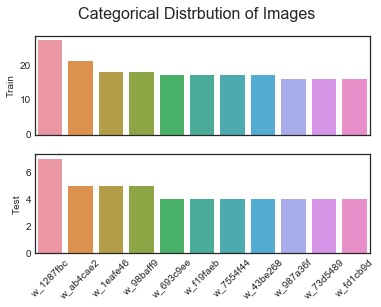

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']


test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']

f,(ax1,ax3) = plt.subplots(2,1,sharex=True)

fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')


fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)

#f.savefig('../figures/train_test_Dist.png')

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        #shear_range = 0.2,
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET50_80_20_split.h5')
model.load_weights('../models/ResNET50_80_20_50batchSize_weights.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.01), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 70 # 
batchSize = 50 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# checkpoint
filepath="../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer, checkpoint])

Epoch 1/70
4/4 [==============================] - 1071s 268s/step - loss: 0.9739 - acc: 0.8000 - val_loss: 10.6739 - val_acc: 0.0800

Epoch 00001: val_acc improved from -inf to 0.08000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-01-0.08.hdf5
Epoch 2/70
4/4 [==============================] - 1024s 256s/step - loss: 0.8928 - acc: 0.7100 - val_loss: 1.0168 - val_acc: 0.7400

Epoch 00002: val_acc improved from 0.08000 to 0.74000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-02-0.74.hdf5
Epoch 3/70
4/4 [==============================] - 1023s 256s/step - loss: 0.6967 - acc: 0.7450 - val_loss: 1.2304 - val_acc: 0.7200

Epoch 00003: val_acc did not improve from 0.74000
Epoch 4/70
4/4 [==============================] - 1047s 262s/step - loss: 0.6310 - acc: 0.7550 - val_loss: 3.1966 - val_acc: 0.4400

Epoch 00004: val_acc did not improve from 0.74000
Epoch 5/70
4/4 [==============================] - 1049s 262s/step - loss: 0.4733

Epoch 43/70
4/4 [==============================] - 978s 245s/step - loss: 0.0850 - acc: 0.9800 - val_loss: 0.4247 - val_acc: 0.8800

Epoch 00043: val_acc did not improve from 0.88000
Epoch 44/70
4/4 [==============================] - 978s 244s/step - loss: 0.1021 - acc: 0.9800 - val_loss: 0.4125 - val_acc: 0.8800

Epoch 00044: val_acc did not improve from 0.88000
Epoch 45/70
4/4 [==============================] - 979s 245s/step - loss: 0.1034 - acc: 0.9700 - val_loss: 0.4036 - val_acc: 0.9000

Epoch 00045: val_acc improved from 0.88000 to 0.90000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-45-0.90.hdf5
Epoch 46/70
4/4 [==============================] - 978s 245s/step - loss: 0.1249 - acc: 0.9550 - val_loss: 0.3921 - val_acc: 0.9000

Epoch 00046: val_acc did not improve from 0.90000
Epoch 47/70
4/4 [==============================] - 979s 245s/step - loss: 0.1014 - acc: 0.9750 - val_loss: 0.3878 - val_acc: 0.9000

Epoch 00047: val_acc did not improve fro

In [0]:
model.save('../models/ResNET_80_20_split_ADAM_LR0.01.h5')  # creates a HDF5 file 'my_model.h5'
# save weights
model.save_weights('../models/ResNET_80_20_split_ADAM_LR0.01_weights.h5')
# to restore a model from a checkpoint see: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [0]:
valLoss, valAcc = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.335040, Validation Accuracy: 0.880000
Train Loss: 0.058789, Train Accuracy: 0.980000


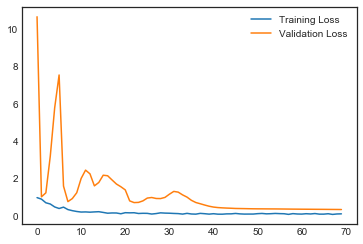

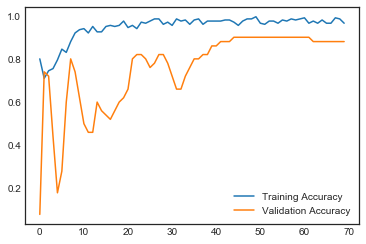

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

0.33504036426544187 0.8799999928474427


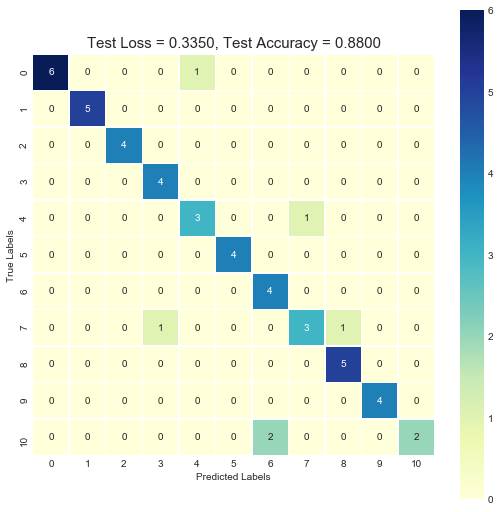

In [0]:
model = load_model('../models/ResNET_80_20_split_ADAM_LR0.01.h5')
model.load_weights('../models/ResNET_80_20_split_ADAM_LR0.01_weights.h5')
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## ResNET with ADAM LR = 0.005 80/20 train/test Split

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

<3 Shape of My Heart <3 : 
Training: (200, 224, 224, 1)
Testing: (50, 224, 224, 1)
(200,)
(200,)
(50,)


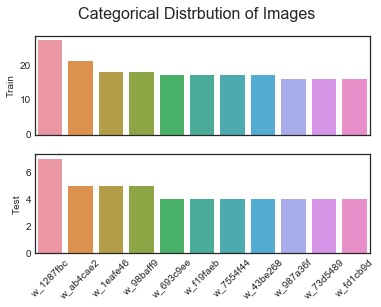

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']


test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']

f,(ax1,ax3) = plt.subplots(2,1,sharex=True)

fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')


fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)

#f.savefig('../figures/train_test_Dist.png')

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        #shear_range = 0.2,
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET_80_20_split_ADAM_LR0.01.h5')
model.load_weights('../models/ResNET_80_20_split_ADAM_LR0.01_weights.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.005), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 70 # 
batchSize = 50 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# checkpoint
filepath="../models/ResNET_80_20_split_ADAM_LR0.005_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" #PREVIOUSLY WRONGLY NAMED PATH!!
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')   #ACCIDENTALLY WROTE 0.01 instead of 0.005 :()
#callbacks_list = [checkpoint]
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer, checkpoint])

Epoch 1/70
4/4 [==============================] - 995s 249s/step - loss: 1.0839 - acc: 0.7450 - val_loss: 8.3966 - val_acc: 0.3200

Epoch 00001: val_acc improved from -inf to 0.32000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-01-0.32.hdf5
Epoch 2/70
4/4 [==============================] - 980s 245s/step - loss: 1.1037 - acc: 0.6600 - val_loss: 2.1198 - val_acc: 0.4600

Epoch 00002: val_acc improved from 0.32000 to 0.46000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-02-0.46.hdf5
Epoch 3/70
4/4 [==============================] - 977s 244s/step - loss: 0.6253 - acc: 0.7900 - val_loss: 2.7279 - val_acc: 0.4400

Epoch 00003: val_acc did not improve from 0.46000
Epoch 4/70
4/4 [==============================] - 1042s 260s/step - loss: 0.4805 - acc: 0.8200 - val_loss: 1.4677 - val_acc: 0.6200

Epoch 00004: val_acc improved from 0.46000 to 0.62000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.01_weights-improvement-04


Epoch 00040: val_acc did not improve from 0.94000
Epoch 41/70
4/4 [==============================] - 978s 244s/step - loss: 0.0773 - acc: 0.9800 - val_loss: 0.3530 - val_acc: 0.9400

Epoch 00041: val_acc did not improve from 0.94000
Epoch 42/70
4/4 [==============================] - 977s 244s/step - loss: 0.0946 - acc: 0.9700 - val_loss: 0.3499 - val_acc: 0.9400

Epoch 00042: val_acc did not improve from 0.94000
Epoch 43/70
4/4 [==============================] - 977s 244s/step - loss: 0.0659 - acc: 0.9900 - val_loss: 0.3470 - val_acc: 0.9400

Epoch 00043: val_acc did not improve from 0.94000
Epoch 44/70
4/4 [==============================] - 977s 244s/step - loss: 0.0940 - acc: 0.9750 - val_loss: 0.3439 - val_acc: 0.9400

Epoch 00044: val_acc did not improve from 0.94000
Epoch 45/70
4/4 [==============================] - 977s 244s/step - loss: 0.0605 - acc: 0.9900 - val_loss: 0.3416 - val_acc: 0.9400

Epoch 00045: val_acc did not improve from 0.94000
Epoch 46/70
4/4 [=================

In [0]:
model.save('../models/ResNET_80_20_split_ADAM_LR0.005.h5')  # creates a HDF5 file 'my_model.h5'
# save weights
model.save_weights('../models/ResNET_80_20_split_ADAM_LR0.005_weights.h5')
# to restore a model from a checkpoint see: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [0]:
valLoss, valAcc = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.317461, Validation Accuracy: 0.940000
Train Loss: 0.033073, Train Accuracy: 1.000000


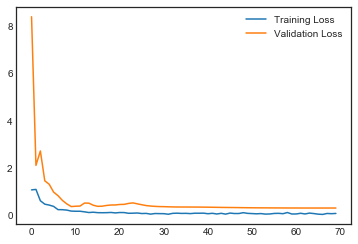

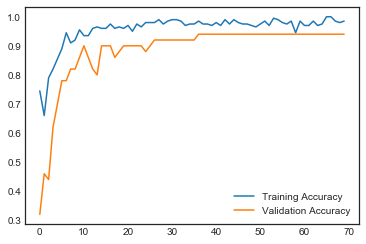

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

0.3174612545967102 0.9399999904632569


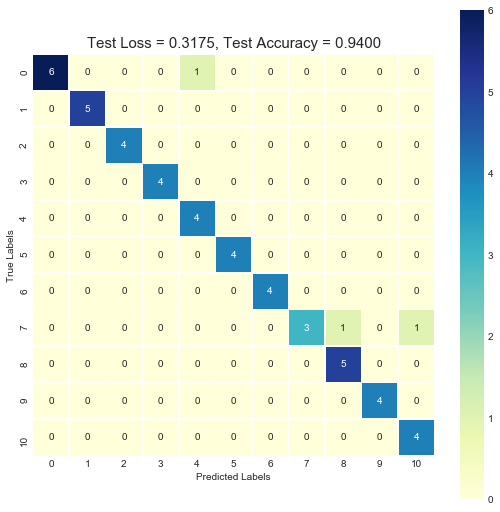

In [0]:
model = load_model('../models/ResNET_80_20_split_ADAM_LR0.005.h5')
model.load_weights('../models/ResNET_80_20_split_ADAM_LR0.005_weights.h5')
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## ResNET with ADAM LR = 0.001 80/20 train/test Split

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

<3 Shape of My Heart <3 : 
Training: (200, 224, 224, 1)
Testing: (50, 224, 224, 1)
(200,)
(200,)
(50,)


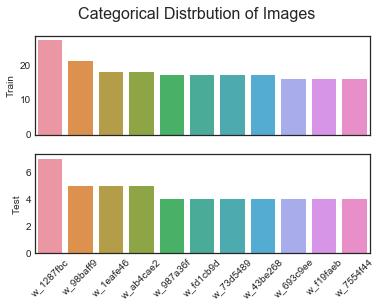

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']


test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']

f,(ax1,ax3) = plt.subplots(2,1,sharex=True)

fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')


fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)

#f.savefig('../figures/train_test_Dist.png')

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        #shear_range = 0.2,
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET50_90_10_split.h5')
model.load_weights('../models/ResNET50_90_10_weights.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 70 # 
batchSize = 50 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# checkpoint
filepath="../models/ResNET_80_20_split_LR0.001-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer, checkpoint])

Epoch 1/70
4/4 [==============================] - 1082s 270s/step - loss: 1.0804 - acc: 0.7150 - val_loss: 3.8688 - val_acc: 0.2600

Epoch 00001: val_acc improved from -inf to 0.26000, saving model to ../models/ResNET_80_20_split_weights-improvement-01-0.26.hdf5
Epoch 2/70
4/4 [==============================] - 1057s 264s/step - loss: 0.9359 - acc: 0.7250 - val_loss: 6.7833 - val_acc: 0.2600

Epoch 00002: val_acc did not improve from 0.26000
Epoch 3/70
4/4 [==============================] - 1058s 264s/step - loss: 0.5925 - acc: 0.7700 - val_loss: 4.9300 - val_acc: 0.2400

Epoch 00003: val_acc did not improve from 0.26000
Epoch 4/70
4/4 [==============================] - 1056s 264s/step - loss: 0.5754 - acc: 0.8200 - val_loss: 4.3895 - val_acc: 0.2800

Epoch 00004: val_acc improved from 0.26000 to 0.28000, saving model to ../models/ResNET_80_20_split_weights-improvement-04-0.28.hdf5
Epoch 5/70
4/4 [==============================] - 1057s 264s/step - loss: 0.5581 - acc: 0.7950 - val_loss

In [0]:
model.save('../models/ResNET50_80_20_split_LR0.001.h5')  # creates a HDF5 file 'my_model.h5'
# save weights
model.save_weights('../models/ResNET50_80_20_LR0.001_weights.h5')
# to restore a model from a checkpoint see: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [0]:
valLoss, valAcc = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.421412, Validation Accuracy: 0.920000
Train Loss: 0.071216, Train Accuracy: 0.975000


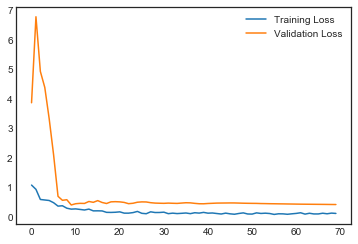

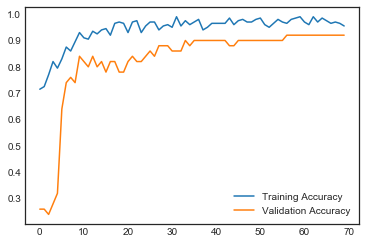

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

0.42141157388687134 0.9199999904632569


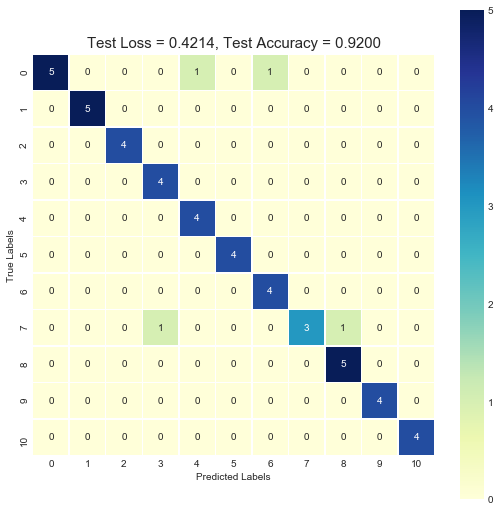

In [0]:
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## ResNET w/ Optimal Learning Rate

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

<3 Shape of My Heart <3 : 
Training: (200, 224, 224, 1)
Testing: (50, 224, 224, 1)
(200,)
(200,)
(50,)


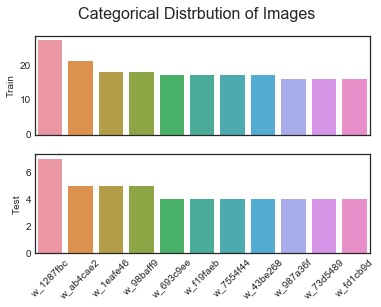

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']


test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']

f,(ax1,ax3) = plt.subplots(2,1,sharex=True)

fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')


fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)

#f.savefig('../figures/train_test_Dist.png')

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 3200        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET_80_20_split_ADAM_LR0.005.h5')
model.load_weights('../models/ResNET_80_20_split_ADAM_LR0.005_weights.h5')
opt = keras.optimizers.Adam(lr=0.004323416)
lr_metric = get_lr_metric(opt)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.004323416), #instead of annealer decay = DR can be set, too
              metrics=['accuracy', lr_metric])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 70 # 
batchSize = 50 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# checkpoint
filepath="../models/ResNET_80_20_split_ADAM_LR0.0043_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')   
#callbacks_list = [checkpoint]
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer, checkpoint])



Epoch 1/70
4/4 [==============================] - 1136s 284s/step - loss: 0.7590 - acc: 0.7700 - lr: 0.0043 - val_loss: 4.7131 - val_acc: 0.4400 - val_lr: 0.0043

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.0043_weights-improvement-01-0.44.hdf5
Epoch 2/70
4/4 [==============================] - 1099s 275s/step - loss: 0.5444 - acc: 0.8000 - lr: 0.0043 - val_loss: 1.1664 - val_acc: 0.7400 - val_lr: 0.0043

Epoch 00002: val_acc improved from 0.44000 to 0.74000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.0043_weights-improvement-02-0.74.hdf5
Epoch 3/70
4/4 [==============================] - 1091s 273s/step - loss: 0.4787 - acc: 0.8100 - lr: 0.0043 - val_loss: 2.3921 - val_acc: 0.6600 - val_lr: 0.0043

Epoch 00003: val_acc did not improve from 0.74000
Epoch 4/70
4/4 [==============================] - 1098s 275s/step - loss: 0.4140 - acc: 0.8450 - lr: 0.0043 - val_loss: 3.7453 - val_acc: 0.3400 - val_lr: 0.0043

Epoch 0

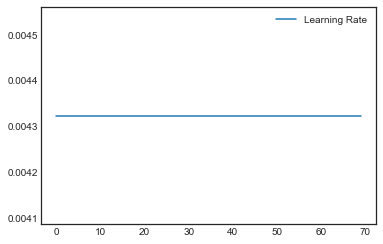

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['lr'], label = "Learning Rate")
plt.legend()
plt.show()

In [0]:
valLoss, valAcc, LR = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc, LR = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.341950, Validation Accuracy: 0.940000
Train Loss: 0.024260, Train Accuracy: 1.000000


In [0]:
model.evaluate(X_test, y_test, verbose=0)

[0.34195014476776125, 0.9399999904632569, 0.004323415923863649]

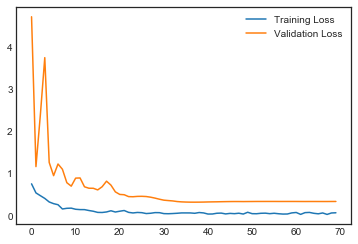

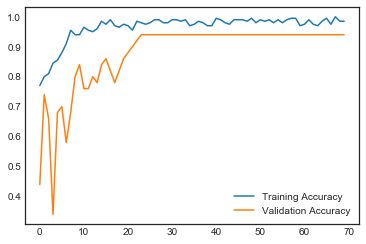

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

0.34195014476776125 0.9399999904632569


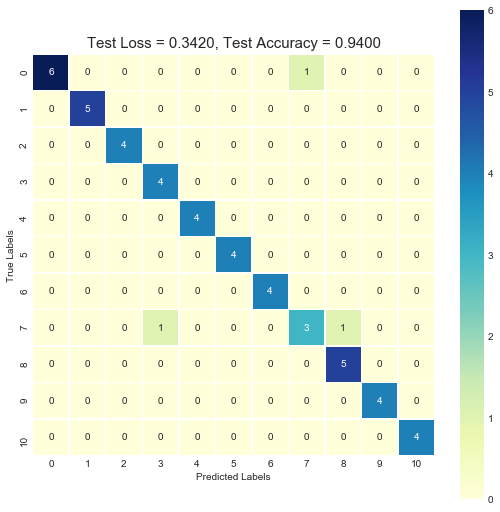

In [0]:
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc, LR = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## RESNET with ADAM, LR = 0.00435 + Decay

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

(200,)
(50,)


In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET_80_20_split_ADAM_LR0.005.h5')
model.load_weights('../models/ResNET_80_20_split_ADAM_LR0.005_weights.h5')
opt = keras.optimizers.Adam(lr=0.004323416)
lr_metric = get_lr_metric(opt)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.004323416,decay = 0.9), #instead of annealer decay = DR can be set, too
              metrics=['accuracy', lr_metric])
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
# Fit the model
Epochs = 50 # 
batchSize = 30 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# checkpoint
filepath="../models/ResNET_80_20_split_ADAM_LR0.0043decay_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')   
#callbacks_list = [checkpoint]
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[checkpoint])



Epoch 1/50
6/6 [==============================] - 960s 160s/step - loss: 6.4826 - acc: 0.3377 - lr: 0.0043 - val_loss: 11.8679 - val_acc: 0.1400 - val_lr: 0.0043

Epoch 00001: val_acc improved from -inf to 0.14000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.0043decay_weights-improvement-01-0.14.hdf5
Epoch 2/50
6/6 [==============================] - 905s 151s/step - loss: 3.6409 - acc: 0.3496 - lr: 0.0043 - val_loss: 8.1914 - val_acc: 0.1600 - val_lr: 0.0043

Epoch 00002: val_acc improved from 0.14000 to 0.16000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.0043decay_weights-improvement-02-0.16.hdf5
Epoch 3/50
6/6 [==============================] - 955s 159s/step - loss: 2.7181 - acc: 0.4111 - lr: 0.0043 - val_loss: 7.5105 - val_acc: 0.2400 - val_lr: 0.0043

Epoch 00003: val_acc improved from 0.16000 to 0.24000, saving model to ../models/ResNET_80_20_split_ADAM_LR0.0043decay_weights-improvement-03-0.24.hdf5
Epoch 4/50
6/6 [==============================] - 857s 143s/

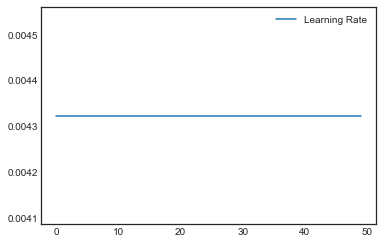

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['lr'], label = "Learning Rate")
plt.legend()
plt.show()

## RESNET with SGD & Cosine Decay

In [0]:
with open ('../input/X_gray', 'rb') as f3:
    X = pickle.load(f3)
with open ('../input/y_gray', 'rb') as f4:
    y = pickle.load(f4)

<3 Shape of My Heart <3 : 
Training: (200, 224, 224, 1)
Testing: (50, 224, 224, 1)
(200,)
(200,)
(50,)


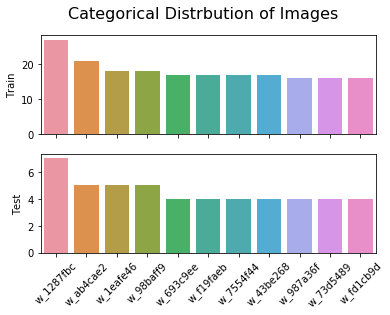

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,stratify=y, random_state =42)
print("<3 Shape of My Heart <3 : ")
print("=========================")
print("Training:", X_train.shape)
print("Testing:", X_test.shape)

print(y_train.shape)
train_top20 = pd.DataFrame(y_train.value_counts())
train_top20.reset_index(inplace=True)
train_top20.columns = ['ID','Counts']


test_top20 = pd.DataFrame(y_test.value_counts())
test_top20.reset_index(inplace=True)
test_top20.columns = ['ID','Counts']

f,(ax1,ax3) = plt.subplots(2,1,sharex=True)

fig1 = sns.barplot(x="ID", y="Counts", data=train_top20, ax=ax1)
fig1.set_ylabel('Train')
fig1.set_xlabel('')


fig3 = sns.barplot(x="ID", y="Counts", data=test_top20, ax=ax3)
fig3.set_ylabel('Test')
fig3.set_xlabel('')
f=plt.xticks(rotation=45)
suptitle("Categorical Distrbution of Images", fontsize=16)

#f.savefig('../figures/train_test_Dist.png')

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
height = 224
width = 224
channels =1
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
#X_val = X_val.reshape(-1,height,width,channels)
y_train = LabelEncoder().fit_transform(y_train)
#y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1))
#y_val = LabelEncoder().fit_transform(y_val)
#y_val = OneHotEncoder().fit_transform(y_val.reshape(-1,1))
y_test = LabelEncoder().fit_transform(y_test)
#y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1))
print(y_train.shape)
#print(y_val.shape)
print(y_test.shape)
classNum = 11#len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
y_test = to_categorical(y_test, num_classes = classNum)
#y_val = to_categorical(y_val, num_classes = classNum)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally only!
        vertical_flip=False,  #  do not randomly flip images vertically!
        fill_mode='nearest',
        zca_whitening = False) # A whitening transform of an image is a linear algebra operation that reduces the redundancy in the matrix of pixel images. Less redundancy in the image is intended to better highlight the structures and features in the image to the learning algorithm.


datagen.fit(X_train, augment=True)
# configure batch size and retrieve one batch of images
#os.makedirs('augmentedImages')
#for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='../augmentedImages', save_prefix='aug', save_format='png'):

Cosine Annealer

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References        
    Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay
        self.batch_since_restart = 0
        self.next_restart = cycle_length
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)        

In [0]:
inputShape = (224,224,1)
model = load_model('../models/ResNET50_80_20_split.h5')
model.load_weights('../models/ResNET50_80_20_50batchSize_weights.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=5e-4, nesterov=True), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])

# Fit the model
Epochs = 70 # 
batchSize = 50 # number of randomly taken samples from features and labels to feed into each epoch 
                # until an epoch limit is reached.
# cosine annealer reference: https://arxiv.org/abs/1608.03983
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
schedule = SGDRScheduler(min_lr=1e-4,
                        max_lr=1e-2,
                        steps_per_epoch = X_train.shape[0] // batchSize,#np.ceil(epoch_size/batch_size),
                        lr_decay=0.9,
                        cycle_length=5,
                        mult_factor=1.5)
# checkpoint
filepath="../models/ResNET_SGD_LR0.01_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[schedule, checkpoint])
              

Epoch 1/70
4/4 [==============================] - 1037s 259s/step - loss: 0.1169 - acc: 0.9800 - val_loss: 4.0105 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to ../models/ResNET_SGD_LR0.01_weights-improvement-01-0.44.hdf5
Epoch 2/70
4/4 [==============================] - 1032s 258s/step - loss: 0.1733 - acc: 0.9550 - val_loss: 0.6830 - val_acc: 0.8200

Epoch 00002: val_acc improved from 0.44000 to 0.82000, saving model to ../models/ResNET_SGD_LR0.01_weights-improvement-02-0.82.hdf5
Epoch 3/70
4/4 [==============================] - 1031s 258s/step - loss: 0.1748 - acc: 0.9500 - val_loss: 2.0704 - val_acc: 0.5400

Epoch 00003: val_acc did not improve from 0.82000
Epoch 4/70
4/4 [==============================] - 1032s 258s/step - loss: 0.1540 - acc: 0.9400 - val_loss: 1.0904 - val_acc: 0.7600

Epoch 00004: val_acc did not improve from 0.82000
Epoch 5/70
4/4 [==============================] - 1061s 265s/step - loss: 0.1273 - acc: 0.9700 - val_loss: 

In [0]:
model.save('../models/ResNET50_SGD_LR001.h5')  # creates a HDF5 file 'my_model.h5'
# save weights
model.save_weights('../models/ResNET50_SGD_LR001_weights.h5')


In [0]:
valLoss, valAcc = model.evaluate(X_test, y_test, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.914548, Validation Accuracy: 0.780000
Train Loss: 0.364087, Train Accuracy: 0.880000


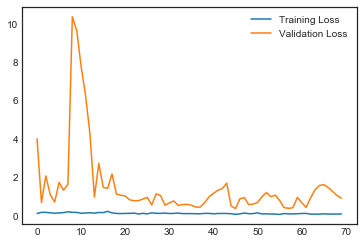

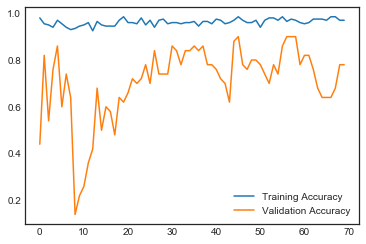

In [0]:
sns.set_color_codes("pastel")
sns.set_style("white")
#sns.lineplot(x='loss', data = )
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()

0.914548282623291 0.7800000047683716


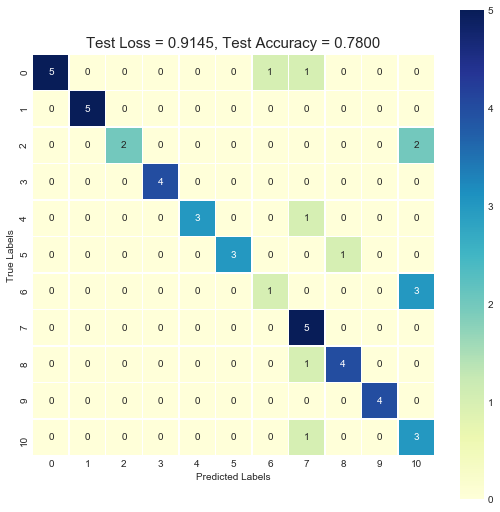

In [0]:
pred = model.predict(X_test) # Predict values of the test set
#y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)
print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_test, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap="YlGnBu");
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 